## Importing the libraries

In [90]:
# For data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import os
import matplotlib.pyplot as plt

# For serialization purpose
import pickle

# For scaling the features
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# For doing multivariate imputation
from sklearn.impute import KNNImputer

# For performing diemsionality reduction
from sklearn.manifold import TSNE

# For visualization of clusters and scatter plot in 3d
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For doing clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import OPTICS
import matplotlib.colors as mcolors
import colorsys

## Reading the data from csv files

In [2]:
# Reading the dataframes
df = pd.DataFrame()

# Loading the traing and test data
train_data = pd.read_csv('../datasets/train.csv') 
test_data = pd.read_csv('../datasets/test.csv')

In [3]:
# Dropping the features
train_data.drop(['Segmentation','ID','Var_1'],axis=1,inplace=True)
test_data.drop(['ID','Var_1'],axis=1,inplace=True)

In [4]:
df = pd.concat([df,train_data,test_data],axis=0)
print(f"The data have {(df.shape)[0]} rows and {(df.shape)[1]} columns")

The data have 10695 rows and 8 columns


## Exploratory data analysis

In [5]:
# Checking 5 random rows 
df.sample(5)

Gender Ever_Married  Age Graduated Profession  Work_Experience  \
545     Male           No   51       Yes     Artist              1.0   
1234    Male          Yes   35       Yes     Artist              1.0   
1852    Male          Yes   71        No  Executive              1.0   
4496  Female          Yes   45       Yes     Artist              NaN   
1244  Female          Yes   83        No     Lawyer              NaN   

     Spending_Score  Family_Size  
545             Low          2.0  
1234        Average          2.0  
1852        Average          4.0  
4496           High          5.0  
1244           High          2.0

In [6]:
duplicate_cnts = df.duplicated().sum()
if duplicate_cnts > 0:
    df.drop_duplicates(inplace=True)
    print(f"{duplicate_cnts} dupicate values removed")
else:
    print("There are no duplicate values")

2019 dupicate values removed


In [7]:
df.isnull().mean()*100

Gender              0.000000
Ever_Married        2.132319
Age                 0.000000
Graduated           1.129553
Profession          1.821116
Work_Experience    11.088059
Spending_Score      0.000000
Family_Size         4.956201
dtype: float64

In [8]:
cols_nan = ['Ever_Married','Graduated','Profession','Family_Size']
for cols in cols_nan:
    df[cols] = df[cols].fillna(df[cols].mode()[0])

In [9]:
# Checking percentage of missing values
df.isnull().mean()*100

Gender              0.000000
Ever_Married        0.000000
Age                 0.000000
Graduated           0.000000
Profession          0.000000
Work_Experience    11.088059
Spending_Score      0.000000
Family_Size         0.000000
dtype: float64

In [10]:
# Ordinal encoding
df['Spending_Score'] = df['Spending_Score'].replace({'Low': 0.0, 'Average': 1.0, 'High': 2.0}).infer_objects(copy=False)

C:\Users\ropar_i9941t3\AppData\Local\Temp\ipykernel_4088\3094096314.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Spending_Score'] = df['Spending_Score'].replace({'Low': 0.0, 'Average': 1.0, 'High': 2.0}).infer_objects(copy=False)


In [11]:
features_to_encode = ['Gender', 'Ever_Married','Graduated','Profession']

# Applying get_dummies to the specified features
encoded_df = pd.get_dummies(df, columns=features_to_encode,dtype=int,drop_first=True)

## Multivariate imputation

In [12]:
# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=2)

# Perform KNN imputation
new_df = pd.DataFrame(imputer.fit_transform(encoded_df), columns=encoded_df.columns)

## Dimensionality reduction
Benefits of Dimensionality Reduction Before Clustering:

- Addresses the Curse of Dimensionality: In high dimensions, distance measures like Euclidean distance become less meaningful, leading to inaccurate clustering results. Dimensionality reduction helps mitigate this by focusing on the most relevant features.
- Improves Clustering Performance: By reducing redundant or irrelevant dimensions, clustering algorithms can identify tighter clusters and achieve better separation between them. This can lead to more accurate and interpretable results.
- Reduces Computational Cost: Clustering algorithms can be computationally expensive, especially on high-dimensional data. Dimensionality reduction reduces the number of features to be processed, leading to faster execution times.

In [47]:
raw_vals = new_df.values

In [48]:
# Dimensionality reduction using TSNE
tsne = TSNE(n_components=3)

reduced_data = tsne.fit_transform(raw_vals)

In [56]:
# Save the array as a pickle file
with open('../artifacts/reduce_data.pkl', 'wb') as f:
    pickle.dump(reduced_data, f)

## Scaling the data
Scaling the features is generally recommended before performing dimensionality reduction techniques like PCA and even some flavors of t-SNE. Here's why:

- Standardizes Units: When features have different units or scales (e.g., centimeters vs. kilometers), algorithms like PCA prioritize features with larger scales, potentially neglecting informative features with smaller values. Scaling ensures all features contribute equally.
- Improves Distance Measures: Dimensionality reduction techniques often rely on distance measures like Euclidean distance. Scaling ensures these distances accurately reflect the relative importance of features in the data.

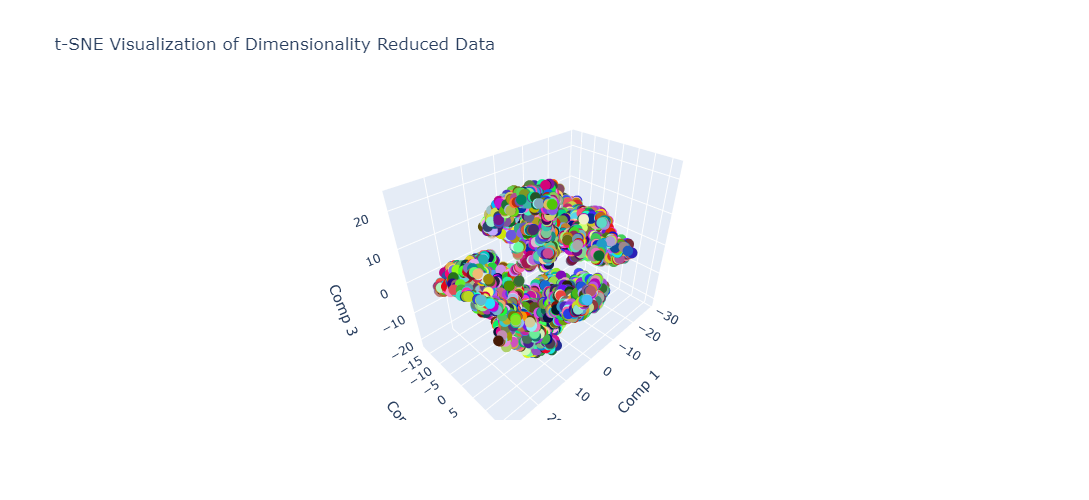

In [57]:
# Define colors for better visualization (replace with your own logic)
colors = np.random.rand(len(rescaled_data), 3) 

# Create a 3D scatter plot using Plotly
fig = make_subplots(specs=[[{"type": "scatter3d"}]])

tsne_trace = go.Scatter3d(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    z=reduced_data[:, 2],
    mode='markers',
    marker=dict(size=6, color=colors),
    name='t-SNE'
)

fig.add_trace(tsne_trace)

# Set plot title and axis labels
fig.update_layout(
    title='t-SNE Visualization of Dimensionality Reduced Data',
    scene=dict(
        xaxis_title='Comp 1',
        yaxis_title='Comp 2',
        zaxis_title='Comp 3'
    ),
    height=500
)

# Render the plot
fig.show()

In [52]:
ss_data = min_max.fit_transform(reduced_data)
minmax_data = scaling.fit_transform(reduced_data)

## Partition Based clustering (K-MEANS)
For doing partition based clustering it is important to first provide the value of k as hyper-parameter. So let's first find the value of k using elbow and sillhoute method.

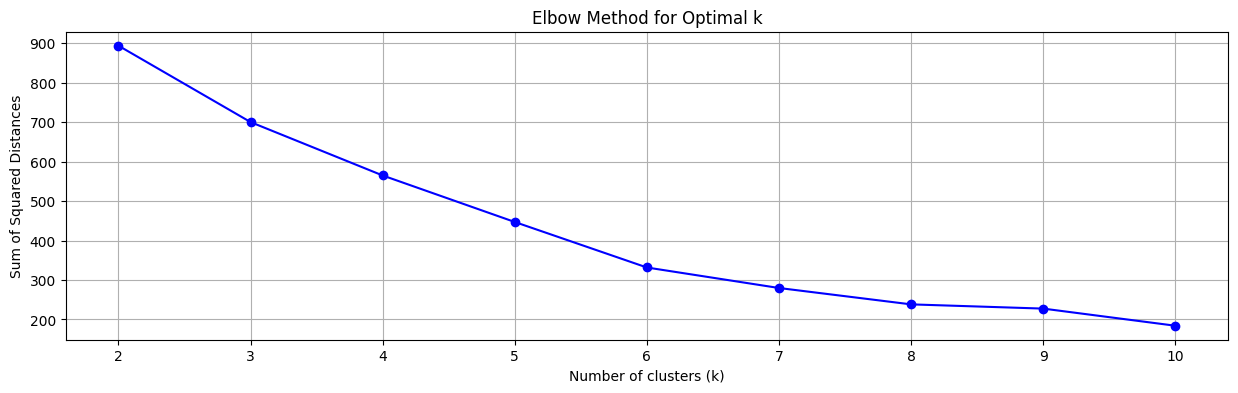

In [84]:
# Calculate sum of squared distances for different values of k
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(ss_data)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(15, 4))
plt.plot(range(2, 11), sse, marker='o', linestyle='-', color='b')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

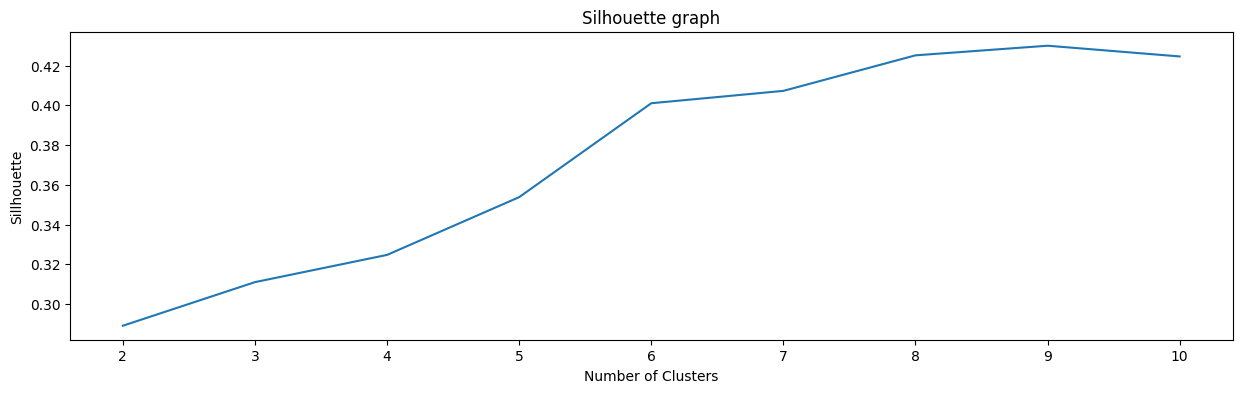

In [83]:
# Empty list to score silhouette score
silhouette_sc = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    cluster_labels = kmeans.fit_predict(ss_data)
    silhouette_avg = silhouette_score(ss_data, cluster_labels)
    silhouette_sc.append(silhouette_avg)

fig,ax = plt.subplots(figsize=(15,4))

plt.plot(range(2, 11), silhouette_sc)
plt.title('Silhouette graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Sillhouette')
plt.show()

In [114]:
kmeans = KMeans(n_clusters = 9)

# Fitting the data
clusters = kmeans.fit_predict(ss_data)

# Get unique cluster labels (excluding noise)
unique_labels_kmeans = set(clusters)

In [103]:
def generate_pastel_colors(num_colors):
    pastel_colors = []
    for i in range(num_colors):

        # Equally spaced hues
        hue = (i * 1.61803398875) / num_colors  # Using the golden ratio for better distribution

        # Higher saturation for more vibrant colors
        saturation = 0.8

        # Lightness to create pastel effect
        lightness = 0.65  # Adjusted lightness for a wider range of colors
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        pastel_colors.append('#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)))
        
    return pastel_colors

In [117]:
num_colors = len(unique_labels)
cluster_colors = generate_pastel_colors(num_colors)

# Create a 3D scatter plot using Plotly
fig = make_subplots(specs=[[{"type": "scatter3d"}]])

# Plot each cluster separately
for cluster_id in unique_labels_kmeans:
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_data = reduced_data[cluster_indices]

    # Using modulo to repeat colors
    cluster_color = cluster_colors[cluster_id % len(cluster_colors)]
    cluster_trace = go.Scatter3d(
        x=cluster_data[:, 0],
        y=cluster_data[:, 1],
        z=cluster_data[:, 2],
        mode='markers',
        marker=dict(size=6, color=cluster_color),  # Assigning specific color to each data point
        name=f'Cluster {cluster_id}'
    )
    fig.add_trace(cluster_trace)

# Set plot title and axis labels
fig.update_layout(
    title='3D Scatter Plot with KMeans Clusters',
    scene=dict(
        xaxis_title='Comp 1',
        yaxis_title='Comp 2',
        zaxis_title='Comp 3'
    ),
    height=500
)

# Render the plot
fig.show()

## Density based clustering (DBSCAN)
https://www.kaggle.com/code/monikanoorkarima/customer-segmentation

In [119]:
# Define DBSCAN parameters
eps = 0.1
min_samples = 5

# Create a DBSCAN object
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the data to DBSCAN
clusters = dbscan.fit_predict(ss_data)

# Get unique cluster labels (excluding noise)
unique_labels_dbscan = set(clusters)

In [121]:
num_colors = len(unique_labels_dbscan)
cluster_colors = generate_pastel_colors(num_colors)

# Create a 3D scatter plot using Plotly
fig = make_subplots(specs=[[{"type": "scatter3d"}]])

# Plot each cluster separately
for cluster_id in unique_labels_dbscan:
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_data = reduced_data[cluster_indices]

    # Using modulo to repeat colors
    cluster_color = cluster_colors[cluster_id % len(cluster_colors)]
    cluster_trace = go.Scatter3d(
        x=cluster_data[:, 0],
        y=cluster_data[:, 1],
        z=cluster_data[:, 2],
        mode='markers',
        marker=dict(size=6, color=cluster_color),  # Assigning specific color to each data point
        name=f'Cluster {cluster_id}'
    )
    fig.add_trace(cluster_trace)

# Set plot title and axis labels
fig.update_layout(
    title='3D Scatter Plot with DBSCAN Clusters',
    scene=dict(
        xaxis_title='Comp 1',
        yaxis_title='Comp 2',
        zaxis_title='Comp 3'
    ),
    height=500
)

# Render the plot
fig.show()